In [166]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [167]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red", "orange"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")

In [168]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            # if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 112.97386065409735, p1: 2.146421740559589
t2: 100.73499389750339, p2: 267.5364827869366
n: [ 0.92003704  0.03448268 -0.39031114]
s: [-0.042231   -0.98159118 -0.18626672]
内積 (n・s): -2.3773241577214962e-17


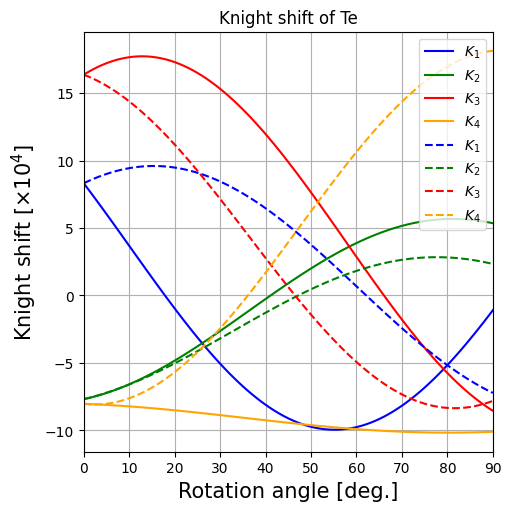

Angle,Shift1[1] value
0,8.315601213783447
1,7.868844898797411
2,7.416900997248594
3,6.9603201331644025
4,6.499658579996836
5,6.035477582888956
6,5.568342674884137
7,5.098822987911171
8,4.627490559384664
9,4.154919635265586
10,3.6816859704310034
11,3.2083661272054576
12,2.7355367729085898
13,2.2637739772748335
14,1.7936525106011723
15,1.3257451434780954
16,0.8606219489568322
17,0.39884960800317365
18,-0.05900928091599905
19,-0.5123968872723018
20,-0.9607608281063899
21,-1.4035548410215306
22,-1.840239449720176
23,-2.2702826212727367
24,-2.6931604143177448
25,-3.1083576174037026
26,-3.5153683766948807
27,-3.913696812276283
28,-4.302857622306946
29,-4.682376674285472
30,-5.051791582707456
31,-5.41065227241099
32,-5.758521526923919
33,-6.094975521144776
34,-6.419604337708363
35,-6.732012466406931
36,-7.031819286058454
37,-7.318659528234874
38,-7.592183722285459
39,-7.852058621112925
40,-8.097967607183717
41,-8.32961107827768
42,-8.546706812507228
43,-8.748990312161231
44,-8.936215125954755

In [169]:
# In the case of Te. (Te1 is on y-bond).
ks = [-0.08e-2, 0.13e-2, -0.05e-2, -0.11e-2, 0.0, 0.0]

E = np.eye(3)
C4 = rotation_matrix([0,0,1], np.pi/2) # for V2.
C2 = rotation_matrix([0,0,1], np.pi) # for V3.
C4i = C4.T # for V4.

Rs = [E, C4, C2, C4i]

theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2)

In [170]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts*10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts*10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2)

In [171]:
# 回転行列(PyTorch版)
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

# 外積(PyTorch版)
def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

# 磁場ベクトル(PyTorch版)
def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

# モデル関数(PyTorch版)
def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C4 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([torch.pi / 2.0])) # for V2.
    C2 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([torch.pi])) # for V3.
    C4i = C4.T # for V4.

    Rs = [E, C4, C2, C4i]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [172]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv', 'sample(4).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv', 'sample4.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6, x7, x8 = x_tensors
y1, y2, y3, y4, y5, y6, y7, y8 = y_tensors

In [173]:
# 損失関数の定義
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return torch.sqrt(squared_diffs.mean())

In [174]:
# 損失関数の和
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [175]:
# 全ての順列を生成
# permutations = list(itertools.permutations([0, 1, 2, 3]))
permutations = [[0, 1, 2, 3]]  # [0, 1, 2, 3] だけを使う

# 最適化のためのobjective関数
def objective(trial, perm):
    # Optunaでパラメータをサンプリング
    k1 = torch.tensor(trial.suggest_float('k1', -15, 15), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -15, 15), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -15, 15), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -15, 15), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', -180.0, 180.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]
    
    # 順列に基づいた出力の取得
    y_p1, y_p2, y_p3, y_p4 = [outputs[i]['shift1'][perm[i]] for i in range(4)]
    y_p5, y_p6, y_p7, y_p8 = [outputs[i+4]['shift2'][perm[i]] for i in range(4)]

    # 損失関数の計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6, y_p7, y7, y_p8, y8)

    return loss.item()

# 最適化ループ
max_global_iterations = 1  # グローバルな最大繰り返し回数
global_iteration = 0

# グローバルな最良結果を保存するための変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 損失関数が0.01以下になるまで以下の計算を繰り返す
while global_best_loss > 1e-2 and global_iteration < max_global_iterations:
    print(f"\nGlobal iteration {global_iteration + 1}")

    # 6通りの組み合わせごとにエポック計算を行うためのループ
    for perm in permutations:
        print(f"Evaluating combination: perm1={perm}, perm2={perm}")

        # 最適化のための変数初期化
        best_epoch0_loss = float('inf')
        best_params = None

        # Optunaを使用してパラメータを最適化
        for _ in range(3):
            # Optunaで最適化
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, perm), n_trials=100)

            # epoch0のLossが最小のパラメータを保持
            if study.best_value < best_epoch0_loss:
                best_epoch0_loss = study.best_value
                best_params = study.best_params

        # エポック計算 (各組み合わせごとに計算)
        if best_params is not None:
            print(f"Starting training for combination: perm1={perm}, perm2={perm}")

            # 最適化されたパラメータで初期化
            k1 = torch.nn.Parameter(torch.tensor(best_params['k1'], dtype=torch.float32))
            k2 = torch.nn.Parameter(torch.tensor(best_params['k2'], dtype=torch.float32))
            k3 = torch.nn.Parameter(torch.tensor(best_params['k3'], dtype=torch.float32))
            k4 = torch.nn.Parameter(torch.tensor(best_params['k4'], dtype=torch.float32))
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1 = torch.nn.Parameter(torch.tensor(best_params['t1'], dtype=torch.float32))
            p1 = torch.nn.Parameter(torch.tensor(best_params['p1'], dtype=torch.float32))
            t2 = torch.nn.Parameter(torch.tensor(best_params['t2'], dtype=torch.float32))
            p2 = torch.nn.Parameter(torch.tensor(best_params['p2'], dtype=torch.float32))
            
            # 既存のパラメータに新しい初期値を設定
            k1.data = torch.tensor(best_params['k1'], dtype=torch.float32)
            k2.data = torch.tensor(best_params['k2'], dtype=torch.float32)
            k3.data = torch.tensor(best_params['k3'], dtype=torch.float32)
            k4.data = torch.tensor(best_params['k4'], dtype=torch.float32)
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1.data = torch.tensor(best_params['t1'], dtype=torch.float32)
            p1.data = torch.tensor(best_params['p1'], dtype=torch.float32)
            t2.data = torch.tensor(best_params['t2'], dtype=torch.float32)
            p2.data = torch.tensor(best_params['p2'], dtype=torch.float32)

            optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
            prev_loss = float('inf')

            # エポックごとのトレーニング
            best_params_during_epoch = None  # エポックごとの最良パラメータ
            best_epoch_loss = float('inf')  # 最良のロスを記録

            # Early Stopping を導入
            early_stopping_patience = 1000
            no_improvement_counter = 0

            # エポックごとのトレーニング
            for epoch in range(300000):
                optimizer.zero_grad()

                outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]

                y_p1, y_p2, y_p3, y_p4 = [outputs[i]['shift1'][perm[i]] for i in range(4)]
                y_p5, y_p6, y_p7, y_p8 = [outputs[i+4]['shift2'][perm[i]] for i in range(4)]

                loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6, y_p7, y7, y_p8, y8)

                if epoch == 0:
                    epoch0_loss = loss.item()
                    if epoch0_loss >= 35:
                        print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                        break
                
                # 最良のロスを持つ場合はパラメータを保存
                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {
                        'k1': k1.item(),
                        'k2': k2.item(),
                        'k3': k3.item(),
                        'k4': k4.item(),
                        'k5': k5.item(),
                        'k6': k6.item(),
                        't1': t1.item(),
                        'p1': p1.item(),
                        't2': t2.item(),
                        'p2': p2.item()
                    }

                if loss.item() > prev_loss:
                    print(f"Loss increased at epoch {epoch}. Stopping training.")
                    break

                prev_loss = loss.item()
                loss.backward()

                optimizer.step()

                # 学習率の更新
                scheduler.step()

                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {...}  # 保存処理
                    no_improvement_counter = 0  # リセット
                else:
                    no_improvement_counter += 1

                if no_improvement_counter >= early_stopping_patience:
                    print(f"Stopping early at epoch {epoch} due to no improvement.")
                    break

                with torch.no_grad():
                    for param in [k1, k2, k3]:
                        param.data = torch.clamp(param.data, -15, 15)
                    for param in [k4]:
                        param.data = torch.clamp(param.data, -15, 15)
                    for param in [t1, t2]:
                        param.data = torch.clamp(param.data, 0.0, 180.0)
                    for param in [p1]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)
                    for param in [p2]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)

                if epoch % 100 == 0:
                    # 勾配を確認（必要に応じて）
                    # for name, param in zip(['k1', 'k2', 'k3', 'k4', 't1', 'p1', 't2', 'p2'], [k1, k2, k3, k4, t1, p1, t2, p2]):
                    #     print(f"{name} grad: {param.grad}")
                    print(f'Epoch {epoch}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()}')
                    # パラメータを表示する
                    print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

            # 最良のパラメータを表示
            if best_params_during_epoch is not None:
                print(f"Best params during epoch training: {best_params_during_epoch}")
                # 最良のパラメータをTensorに変換して使用
                k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
            else:
                print("No improvement in loss during epoch training.")

            # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
            if prev_loss < global_best_loss:
                global_best_loss = prev_loss
                global_best_params = best_params_during_epoch
                global_best_combination = (perm, perm)

            print(f"Finished training for combination: perm1={perm}, perm2={perm}")


    print(f"Global best Loss after iteration {global_iteration + 1}: {global_best_loss}")
    global_iteration += 1

print(f"\nOptimization completed.")
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2025-01-14 21:14:05,824] A new study created in memory with name: no-name-dbd87e25-3f67-4548-873c-2d0333798483
[I 2025-01-14 21:14:05,926] Trial 0 finished with value: 85.83702087402344 and parameters: {'k1': -4.56569945593273, 'k2': 13.395850224728452, 'k3': -6.070732184904893, 'k4': -14.249249604587115, 't1': 19.09598880539356, 'p1': -178.67492943072304, 't2': 156.02326059124644, 'p2': 33.2091643327407}. Best is trial 0 with value: 85.83702087402344.



Global iteration 1
Evaluating combination: perm1=[0, 1, 2, 3], perm2=[0, 1, 2, 3]


[I 2025-01-14 21:14:06,009] Trial 1 finished with value: 66.87696838378906 and parameters: {'k1': -12.301798783454402, 'k2': 3.6874407388681902, 'k3': 0.23550844558680417, 'k4': 4.8706551140857215, 't1': 7.158794173237403, 'p1': 74.21537649015136, 't2': 114.03654922645596, 'p2': 37.93374927495603}. Best is trial 1 with value: 66.87696838378906.
[I 2025-01-14 21:14:06,092] Trial 2 finished with value: 87.64260864257812 and parameters: {'k1': -8.605768729603192, 'k2': 7.345206792522529, 'k3': 14.323864179304373, 'k4': -0.5829363635457767, 't1': 71.96278224865574, 'p1': -27.567904415155198, 't2': 159.98358706859864, 'p2': -53.86773422503539}. Best is trial 1 with value: 66.87696838378906.
[I 2025-01-14 21:14:06,286] Trial 3 finished with value: 62.4063720703125 and parameters: {'k1': 6.555022508521063, 'k2': -6.65217369772105, 'k3': 2.2710300426763403, 'k4': 6.722183527286326, 't1': 95.46033337342884, 'p1': 57.456036645633446, 't2': 107.47634559903423, 'p2': -136.58467599063965}. Best is 

Starting training for combination: perm1=[0, 1, 2, 3], perm2=[0, 1, 2, 3]
Epoch 0, Loss: 32.683292388916016, LR: [0.1]
Parameters: k1=-13.218694686889648, k2=12.486289024353027, k3=-10.421170234680176, k4=-10.144525527954102, k5=0.0, k6=0.0, t1=114.5946273803711, p1=3.2358155250549316, t2=106.29524993896484, p2=-95.80603790283203
Loss increased at epoch 89. Stopping training.
Best params during epoch training: {'k1': -7.995367527008057, 'k2': 13.01071548461914, 'k3': -4.968766212463379, 'k4': -11.010210990905762, 'k5': 0.0, 'k6': 0.0, 't1': 113.330810546875, 'p1': 1.3513574600219727, 't2': 100.74452209472656, 'p2': -92.55606842041016}
Finished training for combination: perm1=[0, 1, 2, 3], perm2=[0, 1, 2, 3]
Global best Loss after iteration 1: 0.29364490509033203

Optimization completed.
Global best Loss: 0.29364490509033203
Global best params: {'k1': -7.995367527008057, 'k2': 13.01071548461914, 'k3': -4.968766212463379, 'k4': -11.010210990905762, 'k5': 0.0, 'k6': 0.0, 't1': 113.3308105

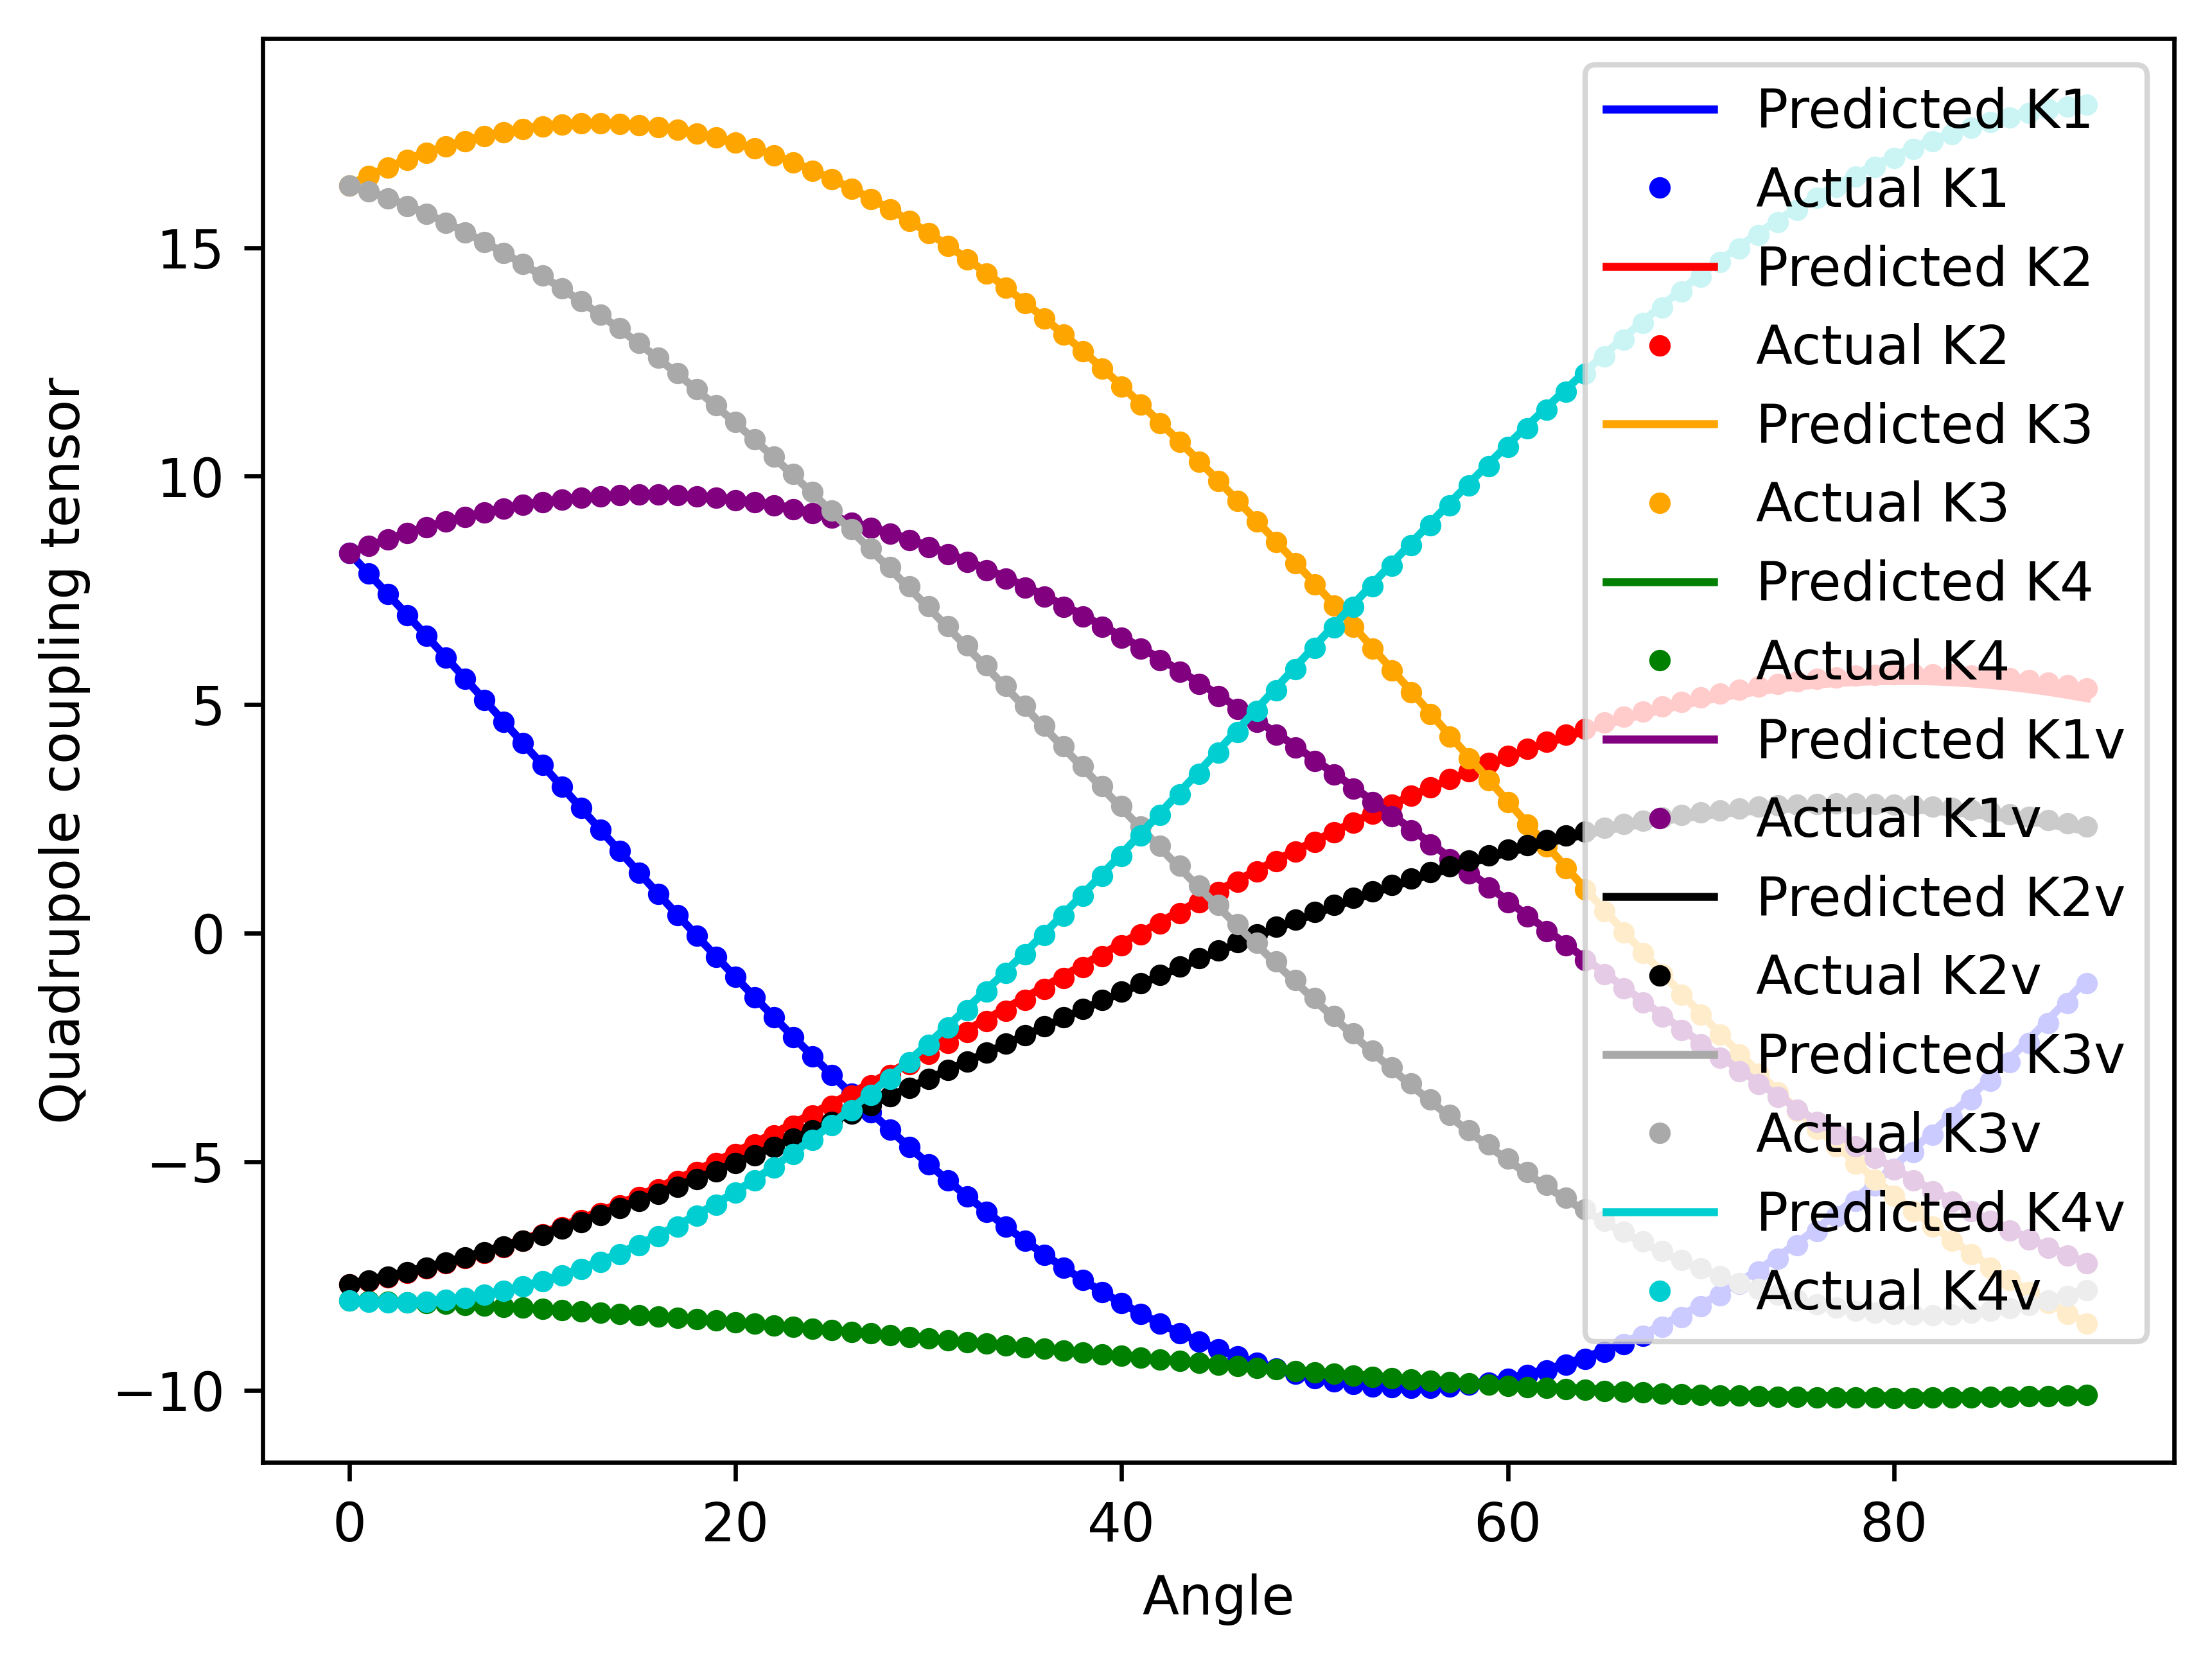

{'k1': -7.995367527008057, 'k2': 13.01071548461914, 'k3': -4.968766212463379, 'k4': -11.010210990905762, 'k5': 0.0, 'k6': 0.0, 't1': 113.330810546875, 'p1': 1.3513574600219727, 't2': 100.74452209472656, 'p2': -92.55606842041016}


In [177]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift1'][3]
y_p5 = outputs[4]['shift2'][0]
y_p6 = outputs[5]['shift2'][1]
y_p7 = outputs[6]['shift2'][2]
y_p8 = outputs[7]['shift2'][3]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K4", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K4", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K1v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K1v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K2v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K2v", color = "black")

plt.plot(x7.detach().numpy(), y_p7.detach().numpy(), label="Predicted K3v", color = "darkgrey") 
plt.plot(x7.detach().numpy(), y7.numpy(), '.', label="Actual K3v", color = "darkgrey")

plt.plot(x8.detach().numpy(), y_p8.detach().numpy(), label="Predicted K4v", color = "darkturquoise") 
plt.plot(x8.detach().numpy(), y8.numpy(), '.', label="Actual K4v", color = "darkturquoise")

plt.xlabel("Angle")
plt.ylabel("Quadrupole coupling tensor")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)